In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix

# Paths
train_dir = "E:/posture-detection/train"
test_dir = "E:/posture-detection/test"

# Image size and batch size
img_size = (224, 224)
batch_size = 32

# 1. Data Loading with Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.1,
    brightness_range=(0.7, 1.3),
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# 2. Build the CNN model 
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(train_generator.num_classes, activation='softmax')
])

# 3. Compile the Model
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 4. Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_posture_model.h5', monitor='val_accuracy', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# 5. Train the Model
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=test_generator,
    callbacks=[early_stop, checkpoint, reduce_lr]
)


Found 1303 images belonging to 4 classes.
Found 329 images belonging to 4 classes.
Epoch 1/100
41/41 [==============================] - 45s 1s/step - loss: 2.5116 - accuracy: 0.3814 - val_loss: 1.2813 - val_accuracy: 0.6626 - lr: 1.0000e-04
Epoch 2/100
41/41 [==============================] - 40s 965ms/step - loss: 1.3152 - accuracy: 0.4259 - val_loss: 2.6634 - val_accuracy: 0.6626 - lr: 1.0000e-04
Epoch 3/100
41/41 [==============================] - 39s 951ms/step - loss: 1.2019 - accuracy: 0.4781 - val_loss: 2.7544 - val_accuracy: 0.6626 - lr: 1.0000e-04
Epoch 4/100
41/41 [==============================] - 39s 951ms/step - loss: 1.1750 - accuracy: 0.4651 - val_loss: 3.1677 - val_accuracy: 0.6626 - lr: 1.0000e-04
Epoch 5/100
41/41 [==============================] - 40s 959ms/step - loss: 1.1877 - accuracy: 0.4896 - val_loss: 2.1634 - val_accuracy: 0.6626 - lr: 1.0000e-04
Epoch 6/100
41/41 [==============================] - 39s 942ms/step - loss: 1.1296 - accuracy: 0.4981 - val_loss: 1

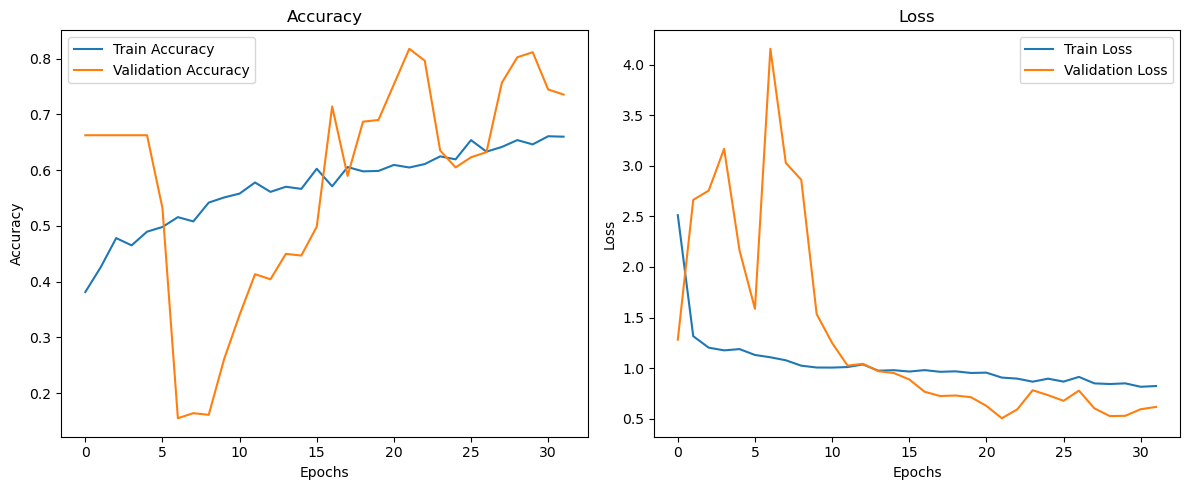

11/11 [==============================] - 3s 224ms/step
Classification Report:

                 precision    recall  f1-score   support

     looks good       0.53      0.58      0.55        59
 shoulders back       0.93      0.84      0.89        51
         sit up       0.00      0.00      0.00         1
straighten head       0.88      0.88      0.88       218

       accuracy                           0.82       329
      macro avg       0.59      0.58      0.58       329
   weighted avg       0.82      0.82      0.82       329



c:\Users\muham\anaconda3\envs\earthquake\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\muham\anaconda3\envs\earthquake\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\muham\anaconda3\envs\earthquake\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r

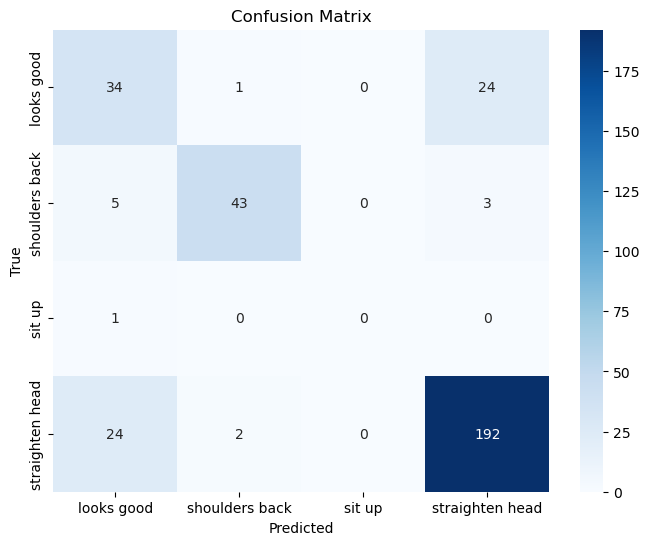

In [ ]:
# 6. Plot Accuracy and Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="Train Accuracy")
plt.plot(history.history['val_accuracy'], label="Validation Accuracy")
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

# 7. Evaluate the Model
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes
labels = list(test_generator.class_indices.keys())

# Classification Report
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=labels))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# 8. Save Final Model
model.save("CNN_final_posture_model.h5")

1/1 [==============================] - 0s 69ms/step


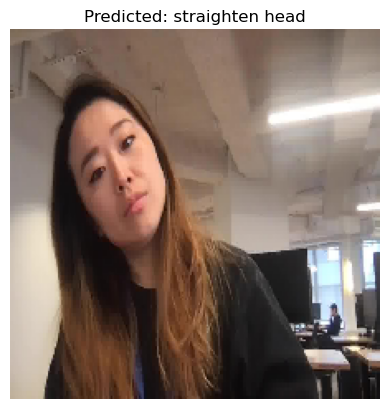

In [10]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Load the trained model
model = load_model(r'E:\posture-detection\best_posture_model.h5')  

# Define the class labels
class_labels = ['looks good', 'shoulders back', 'sit up', 'straighten head']

# Load and preprocess the image
img_path = "test1.jpg"
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.0  # Normalize

# Predict
pred = model.predict(img_array)
predicted_class = np.argmax(pred)
label = class_labels[predicted_class]

plt.imshow(img)
plt.title(f"Predicted: {label}")
plt.axis('off')
plt.show()


In [ ]:
import cv2
from tensorflow.keras.models import load_model
import numpy as np

# Load model
model = load_model(r"E:\posture-detection\best_posture_model.h5")
class_labels = ['looks good', 'shoulders back', 'sit up', 'straighten head']

# Start webcam
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Preprocess frame
    img = cv2.resize(frame, (224, 224))
    img_array = np.expand_dims(img / 255.0, axis=0)

    # Predict
    pred = model.predict(img_array)
    label = class_labels[np.argmax(pred)]

    # Display label
    cv2.putText(frame, label, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 
                1, (0, 255, 0), 2, cv2.LINE_AA)
    cv2.imshow("Posture Detection", frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


1/1 [==============================] - 0s 25ms/step
